In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
import random
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure, save_factory, PlotConfig, format_plots, ONTOGENY_AGE_CMAP, add_identity, legend
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
format_plots()
c = PlotConfig()

In [3]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [4]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]

In [5]:
usage_mtx= data_all.copy()
data_labels = usage_mtx.index.get_level_values('age').to_numpy()

## Cluster syllable usage male

In [6]:
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 [Index([9, 11, 18, 21, 25, 28, 33, 36, 38], dtype='object')]
Cluster 1 [Index([0, 2, 3, 4, 8, 10, 12, 16, 17, 19, 34, 37], dtype='object')]
Cluster 2 [Index([1, 7, 15, 20, 23, 24, 26], dtype='object')]
Cluster 3 [Index([5, 6, 13, 14, 22, 27, 29, 30, 31, 32, 35, 39], dtype='object')]


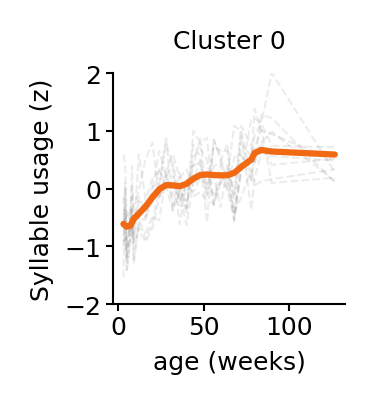

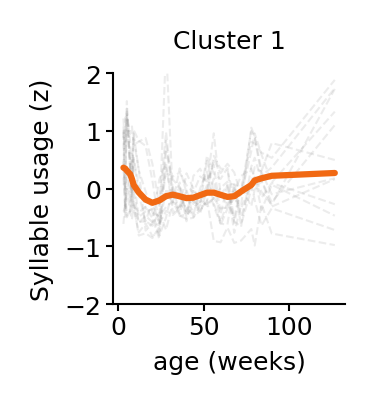

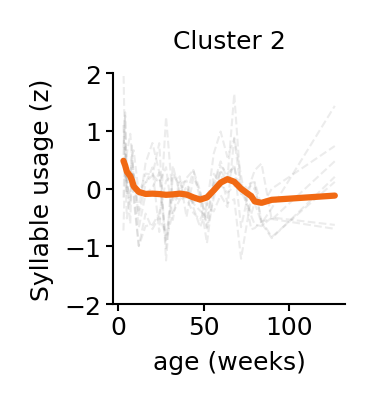

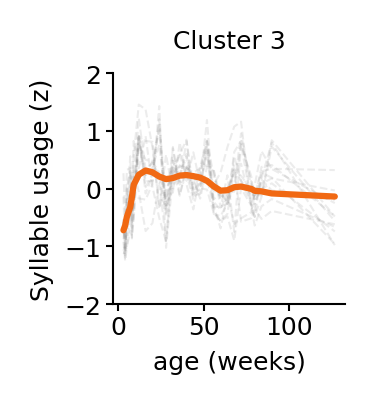

In [7]:
n_clusters = 4
sigma=1.5
clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(StandardScaler().fit_transform(usage_mtx).T)
scaled_df = pd.DataFrame(StandardScaler().fit_transform(usage_mtx), index=usage_mtx.index, columns=usage_mtx.columns.to_numpy())
for i in range(n_clusters):
    fig = figure(1, 1)
    tmp = scaled_df.iloc[:, clusters == i].groupby('age').mean()
    print(f'Cluster {i}', [tmp.columns])
    plt.plot(tmp, c='gray', lw=0.5, alpha=0.15,linestyle='--')
    #plt.plot(tmp, c='w', lw=0.75,linestyle='--')
    m = tmp.mean(1)
    plt.plot(pd.Series(gaussian_filter(m, sigma=sigma), index=tmp.index), c='#f16913', lw=1.5)
    plt.title(f'Cluster {i}')
    plt.xlabel('age (weeks)')
    plt.ylabel('Syllable usage (z)')
    plt.ylim([-2,2])
    sns.despine()
    fig.savefig(c.dana_save_path / "fig3"/ f'female_cluster-{i}.pdf')

In [8]:
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

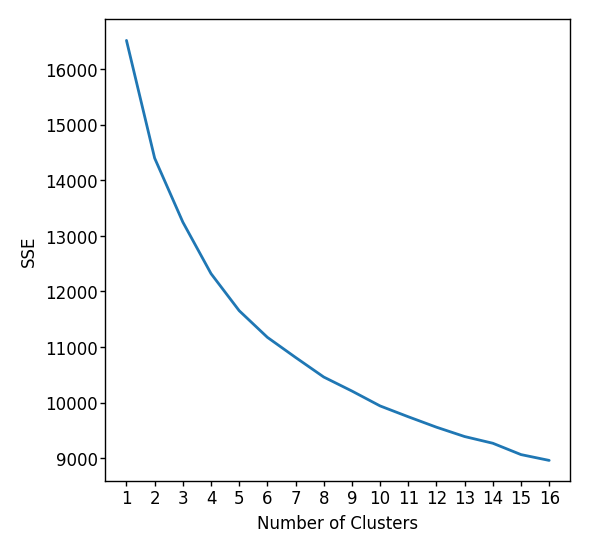

elbow point: SSE  5
elbow point: sill  3


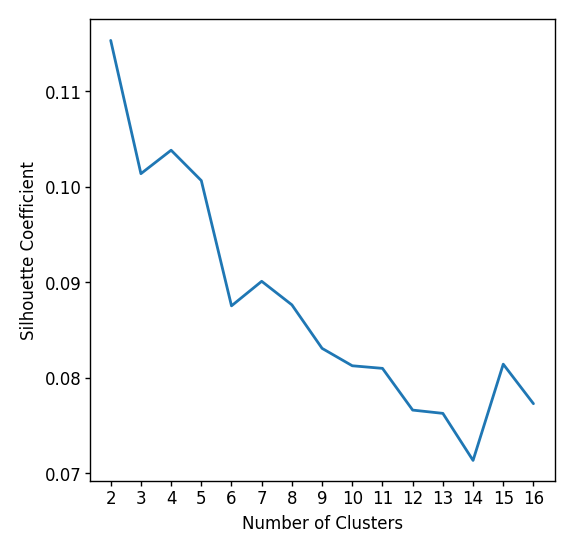

In [9]:
# explore number of clusters
scaler = StandardScaler()
scaled_features = scaler.fit_transform(usage_mtx)


kmeans_kwargs = {"init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 42}

# A list holds the SSE values for each k
sse = []
nclust=16
for k in range(1, nclust+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit_predict(scaled_features)
    sse.append(kmeans.inertia_)

#plt.style.use("fivethirtyeight")
plt.plot(range(1, nclust+1), sse)
plt.xticks(range(1, nclust+1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# figure out elbow point
kl = KneeLocator(range(1, nclust+1), sse, curve="convex", direction="decreasing")
print('elbow point: SSE ', kl.elbow)

# second method
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, nclust+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    #kmeans.fit(scaled_features)
    kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

kl = KneeLocator(range(2, nclust+1), silhouette_coefficients, curve="convex", direction="decreasing")
print('elbow point: sill ', kl.elbow)

#plt.style.use("seaborn")
plt.plot(range(2, nclust+1), silhouette_coefficients)
plt.xticks(range(2, nclust+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

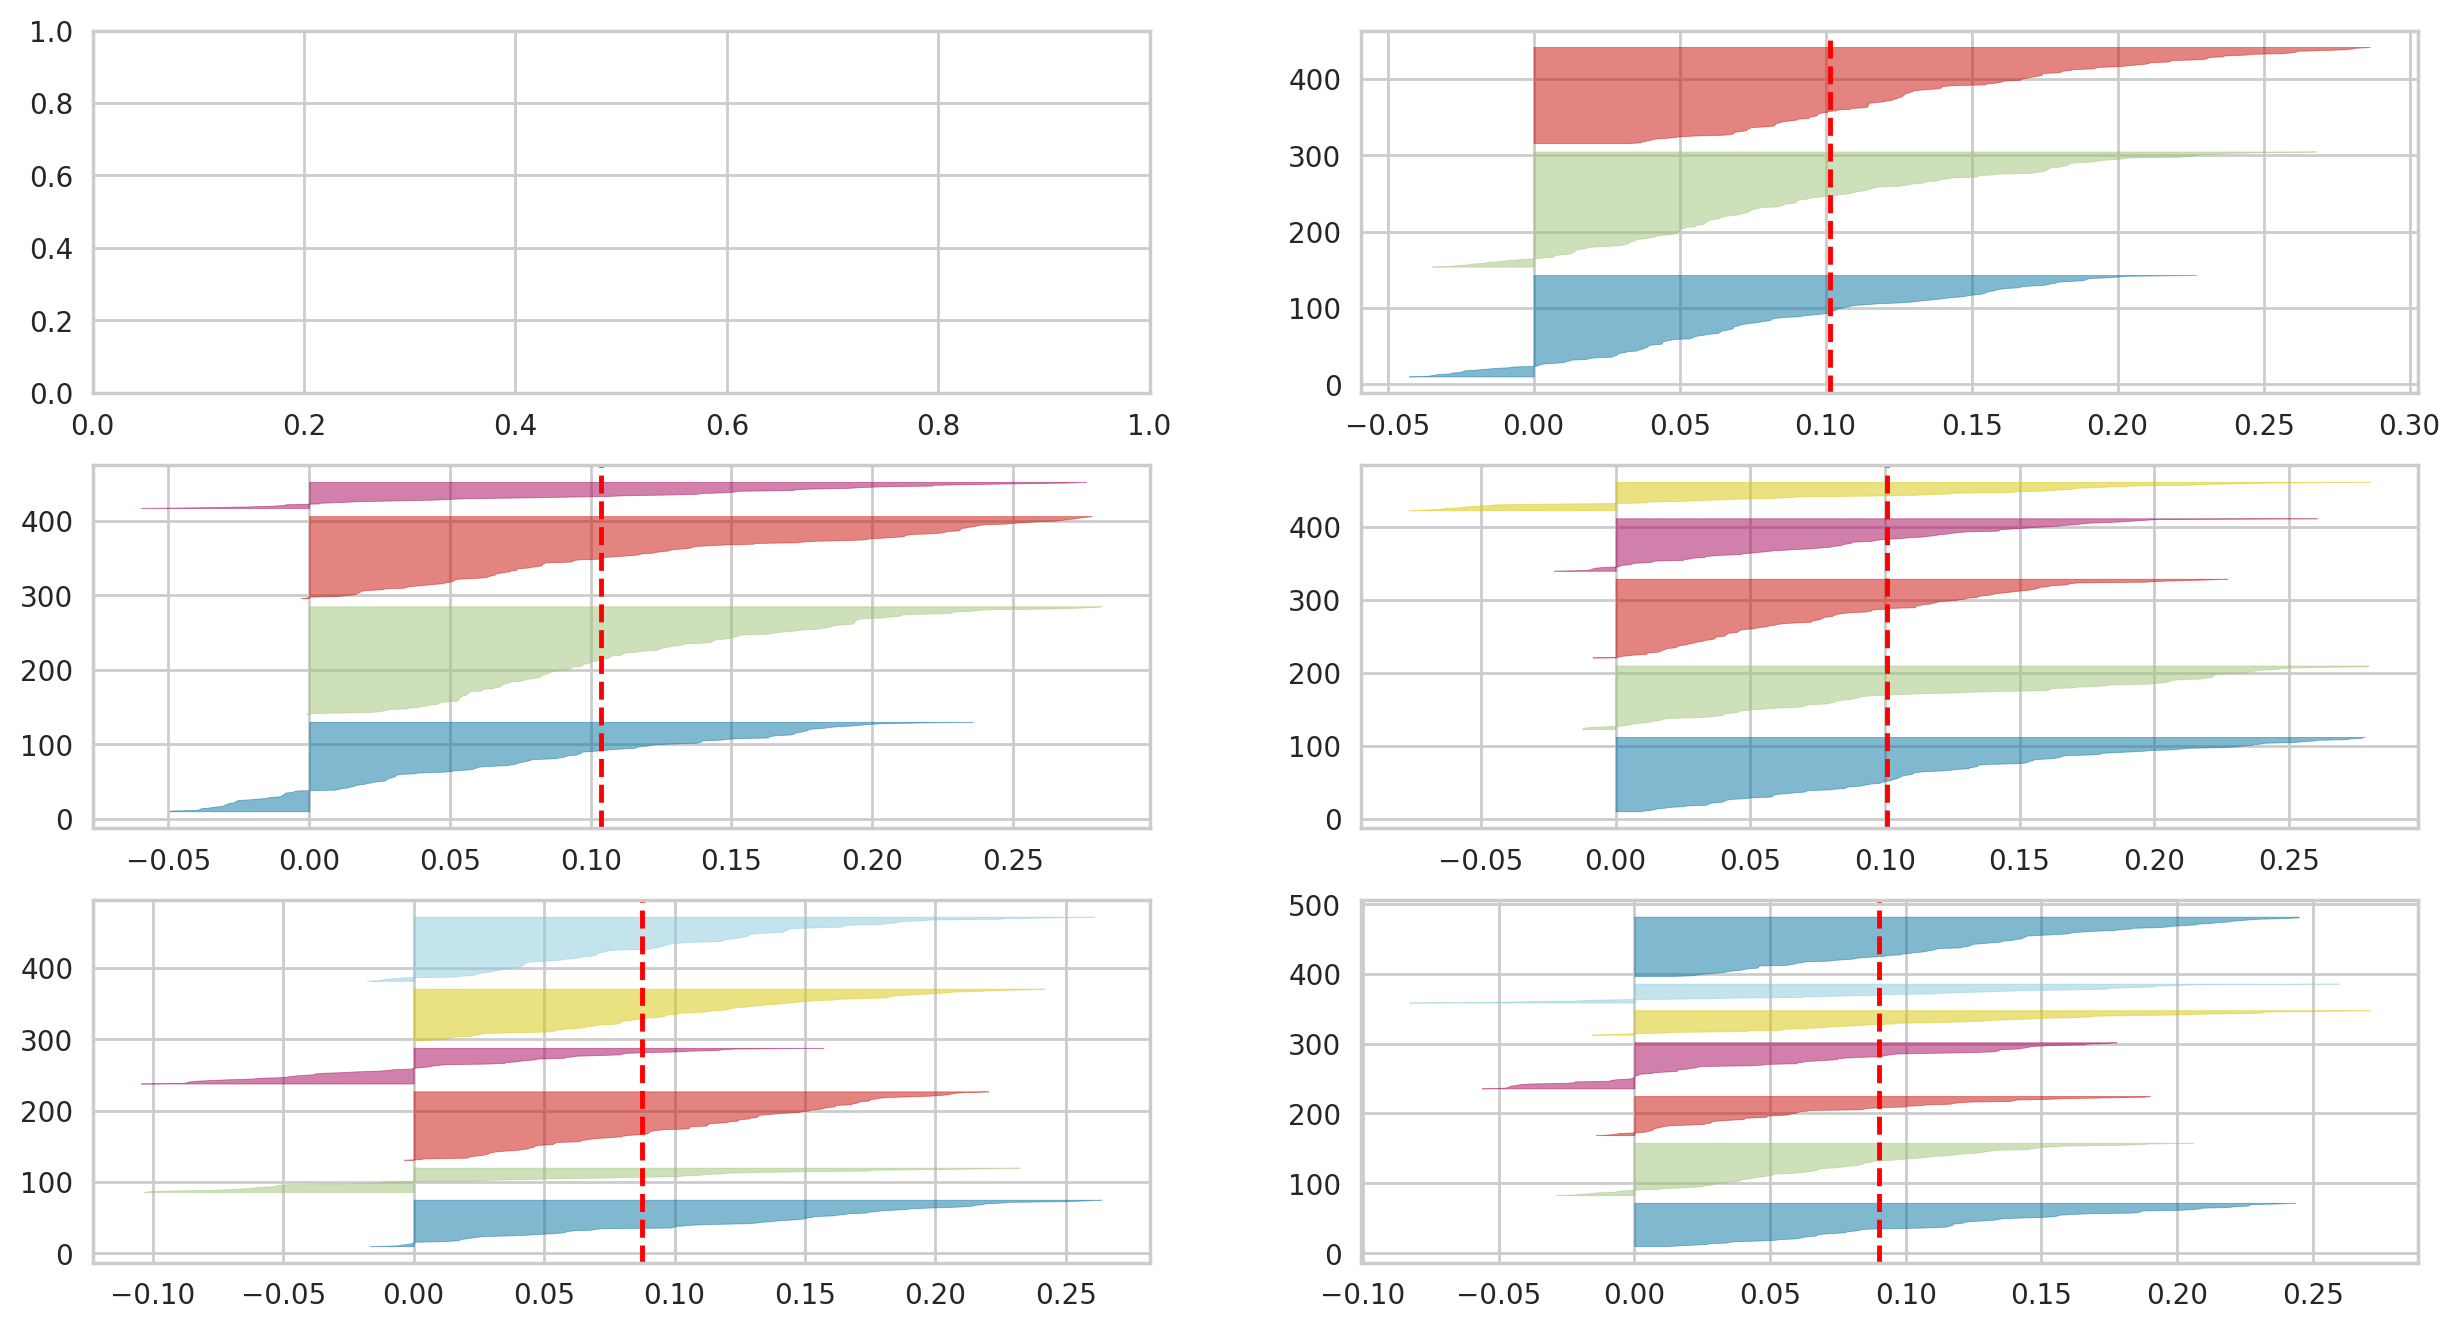

In [10]:
from yellowbrick.cluster import SilhouetteVisualizer
nclust=8
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in range(3, nclust+1):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, **kmeans_kwargs)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(scaled_features) 